In [1]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_validate, learning_curve, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

### **Data Exploration**

In [3]:
# Load the dataset
migration_df = pd.read_csv('bird_migration.csv')
migration_df.info()
migration_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61920 entries, 0 to 61919
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          61920 non-null  int64  
 1   altitude            61920 non-null  int64  
 2   date_time           61920 non-null  object 
 3   device_info_serial  61920 non-null  int64  
 4   direction           61477 non-null  float64
 5   latitude            61920 non-null  float64
 6   longitude           61920 non-null  float64
 7   speed_2d            61477 non-null  float64
 8   bird_name           61920 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 4.3+ MB


,Unnamed: 0,altitude,date_time,device_info_serial,direction,latitude,longitude,speed_2d,bird_name
0,0,71,2013-08-15 00:18:08+00,851,-150.469753,49.419860,2.120733,0.150000,Eric
1,1,68,2013-08-15 00:48:07+00,851,-136.151141,49.419880,2.120746,2.438360,Eric
2,2,68,2013-08-15 01:17:58+00,851,160.797477,49.420310,2.120885,0.596657,Eric
3,3,73,2013-08-15 01:47:51+00,851,32.769360,49.420359,2.120859,0.310161,Eric
4,4,69,2013-08-15 02:17:42+00,851,45.191230,49.420331,2.120887,0.193132,Eric


In [88]:
# Display the statistics of the dataset
migration_df.describe()

,Unnamed: 0,altitude,device_info_serial,direction,latitude,longitude,speed_2d
count,61920.000000,61920.000000,61920.000000,61477.000000,61920.000000,61920.000000,61477.000000
mean,30959.500000,52.313275,849.328505,-4.610841,30.227762,-8.953367,2.558987
std,17874.908671,136.435498,12.835870,102.786009,14.809813,8.478471,3.576039
min,0.000000,-1010.000000,833.000000,-179.997929,12.354424,-17.626145,0.000000
25%,15479.750000,2.000000,833.000000,-89.679759,15.393138,-16.761302,0.410000
50%,30959.500000,14.000000,851.000000,-10.983115,30.424481,-9.662089,1.209049
75%,46439.250000,84.000000,864.000000,81.964778,49.999572,2.603591,3.059444
max,61919.000000,6965.000000,864.000000,180.000000,51.518452,4.857561,63.488066


In [89]:
# Check for unique, missing and duplicated values
inspection_df = pd.DataFrame({
    'Unique': migration_df.nunique(),
    'Missing': migration_df.isnull().sum(),
    'Type': migration_df.dtypes,
    'Sample': migration_df.loc[0],
    'Duplicate': migration_df.duplicated().sum()
})
inspection_df

,Unique,Missing,Type,Sample,Duplicate
Unnamed: 0,61920,0,int64,0,0
altitude,1360,0,int64,71,0
date_time,61837,0,object,2013-08-15 00:18:08+00,0
device_info_serial,3,0,int64,851,0
direction,61468,443,float64,-150.469753,0
latitude,61052,0,float64,49.41986,0
longitude,60893,0,float64,2.120733,0
speed_2d,27277,443,float64,0.15,0
bird_name,3,0,object,Eric,0


In [90]:
# Count the samples for each class
class_counts = migration_df['bird_name'].value_counts()
class_counts

bird_name
Nico     21121
Sanne    21004
Eric     19795
Name: count, dtype: int64

### **Data Visualization**

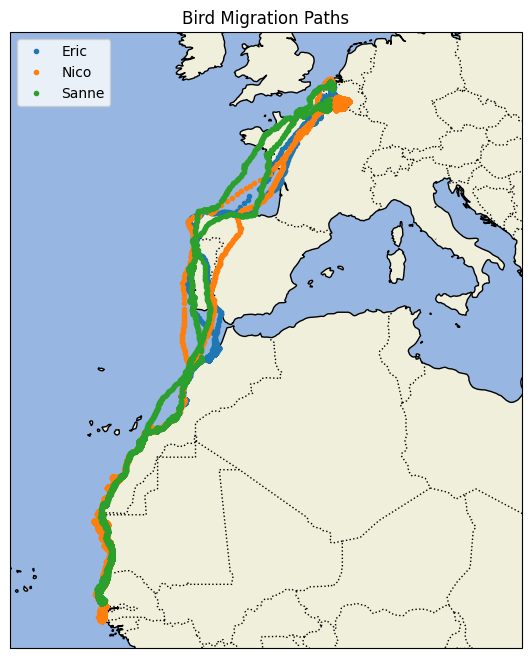

In [9]:
# Vizualize the bird migration using cartopy
bird_names = pd.unique(migration_df.bird_name)
plt.figure(figsize=(8,8))

# Configure the map features
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent((-25.0,20.0,52.0,10.0))
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS,linestyle=":")

# Plot each bird migration path
for name in bird_names:
    i = migration_df["bird_name"] == name
    x, y = migration_df.longitude[i], migration_df.latitude[i]
    ax.plot(x, y, ".", transform=ccrs.Geodetic(), label=name)

plt.title("Bird Migration Paths")
plt.legend(loc="upper left")
plt.show()

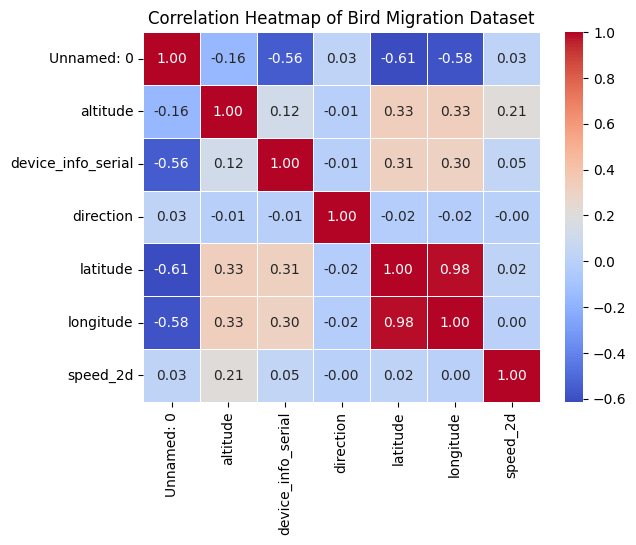

In [5]:
# Visualize the correlation heatmap of the dataset
corr = migration_df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Bird Migration Dataset')
plt.show()

### **Data Preprocessing**

In [91]:
# Impute missing values using KNNImputer since it is a time series dataset
imputer = KNNImputer(n_neighbors=15)
migration_df[['direction', 'speed_2d']] = imputer.fit_transform(migration_df[['direction', 'speed_2d']])
migration_df[['direction', 'speed_2d']].isnull().sum()

direction    0
speed_2d     0
dtype: int64

In [92]:
# Convert and extract useful features from 'date_time'
migration_df['date_time'] = pd.to_datetime(migration_df['date_time'])
migration_df['minute'] = migration_df['date_time'].dt.minute
migration_df['hour'] = migration_df['date_time'].dt.hour
migration_df['day'] = migration_df['date_time'].dt.day
migration_df['month'] = migration_df['date_time'].dt.month

migration_df.head()

,Unnamed: 0,altitude,date_time,device_info_serial,direction,latitude,longitude,speed_2d,bird_name,minute,hour,day,month
0,0,71,2013-08-15 00:18:08+00:00,851,-150.469753,49.419860,2.120733,0.150000,Eric,18,0,15,8
1,1,68,2013-08-15 00:48:07+00:00,851,-136.151141,49.419880,2.120746,2.438360,Eric,48,0,15,8
2,2,68,2013-08-15 01:17:58+00:00,851,160.797477,49.420310,2.120885,0.596657,Eric,17,1,15,8
3,3,73,2013-08-15 01:47:51+00:00,851,32.769360,49.420359,2.120859,0.310161,Eric,47,1,15,8
4,4,69,2013-08-15 02:17:42+00:00,851,45.191230,49.420331,2.120887,0.193132,Eric,17,2,15,8


In [93]:
# Drop unnecessary column
migration_df.drop(columns=['Unnamed: 0', 'bird_name', 'device_info_serial', 'date_time'], inplace=True)
migration_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61920 entries, 0 to 61919
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   altitude   61920 non-null  int64  
 1   direction  61920 non-null  float64
 2   latitude   61920 non-null  float64
 3   longitude  61920 non-null  float64
 4   speed_2d   61920 non-null  float64
 5   minute     61920 non-null  int32  
 6   hour       61920 non-null  int32  
 7   day        61920 non-null  int32  
 8   month      61920 non-null  int32  
dtypes: float64(4), int32(4), int64(1)
memory usage: 3.3 MB


### **Model Training**

In [94]:
# Normalize the features and seperate the target variables
features = migration_df.drop(columns=['latitude', 'longitude'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [95]:
# Split the dataset into features and target variables
X1 = pd.DataFrame(scaled_features, columns=features.columns)
y1 = migration_df['latitude']

X2 = pd.DataFrame(scaled_features, columns=features.columns)
y2 = migration_df['longitude']

X3 = pd.DataFrame(scaled_features, columns=features.columns)
y3 = migration_df[['latitude', 'longitude']]

In [96]:
# Split the dataset into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

train_test_shape = pd.DataFrame({
    'Training' : (X1_train.shape[0], y1_train.shape[0]),
    'Testing' : (X1_test.shape[0], y1_test.shape[0]),
    'Total' : (X1.shape[0], y1.shape[0])
})
train_test_shape

,Training,Testing,Total
0,49536,12384,61920
1,49536,12384,61920


In [97]:
# Train a decision tree models for latitude
dt_lat_model = DecisionTreeRegressor(random_state=42)
dt_lat_model.fit(X1_train, y1_train)

# Train a decision tree models for longitude
dt_long_model = DecisionTreeRegressor(random_state=42)
dt_long_model.fit(X2_train, y2_train)

# Train a multi-output random forest model for latitude and longitude
multi_rf_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
multi_rf_model.fit(X3_train, y3_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

### **Model Evaluation**

In [98]:
# Evaluate the models using regression metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, r2, mae

mse1, r21, mae1 = evaluate_model(dt_lat_model, X1_test, y1_test)
mse2, r22, mae2 = evaluate_model(dt_long_model, X2_test, y2_test)
mse3, r23, mae3 = evaluate_model(multi_rf_model, X3_test, y3_test)

# Create a DataFrame to compare the models
model_comparison = pd.DataFrame({
    'Model': ['Decision Tree (Latitude)', 'Decision Tree (Longitude)', 'Multi-Output Random Forest'],
    'MAE': [mae1, mae2, mae3],
    'MSE': [mse1, mse2, mse3],
    'R2': [r21, r22, r23]
})
model_comparison

,Model,MAE,MSE,R2
0,Decision Tree (Latitude),5.315457,101.758728,0.532555
1,Decision Tree (Longitude),2.701092,28.715641,0.596913
2,Multi-Output Random Forest,3.776369,33.676986,0.776460


In [106]:
# Evaluate the models using cross-validation
dt_lat_val = cross_validate(dt_lat_model, X1, y1, n_jobs=-1, return_train_score=True)
dt_long_val = cross_validate(dt_long_model, X2, y2, n_jobs=-1, return_train_score=True)
multi_rf_val = cross_validate(multi_rf_model, X3, y3, n_jobs=-1, return_train_score=True)

# Create a dataframe to store the cross-validation results
cv_results = pd.DataFrame({
    'Model': ['Decision Tree (Latitude)', 'Decision Tree (Longitude)', 'Multi-Output Random Forest'],
    'Test Score': [dt_lat_val['test_score'].mean(), dt_long_val['test_score'].mean(), multi_rf_val['test_score'].mean()],
    'Train Score': [dt_lat_val['train_score'].mean(), dt_long_val['train_score'].mean(), multi_rf_val['train_score'].mean()],
    'Fit Time': [dt_lat_val['fit_time'].mean(), dt_long_val['fit_time'].mean(), multi_rf_val['fit_time'].mean()],
    'Score Time': [dt_lat_val['score_time'].mean(), dt_long_val['score_time'].mean(), multi_rf_val['score_time'].mean()]
})
cv_results

,Model,Test Score,Train Score,Fit Time,Score Time
0,Decision Tree (Latitude),-1.247670,1.000000,1.011716,0.008708
1,Decision Tree (Longitude),-1.092319,1.000000,1.248086,0.009884
2,Multi-Output Random Forest,-0.699872,0.972684,170.521711,0.924296


### **Model Visualization**

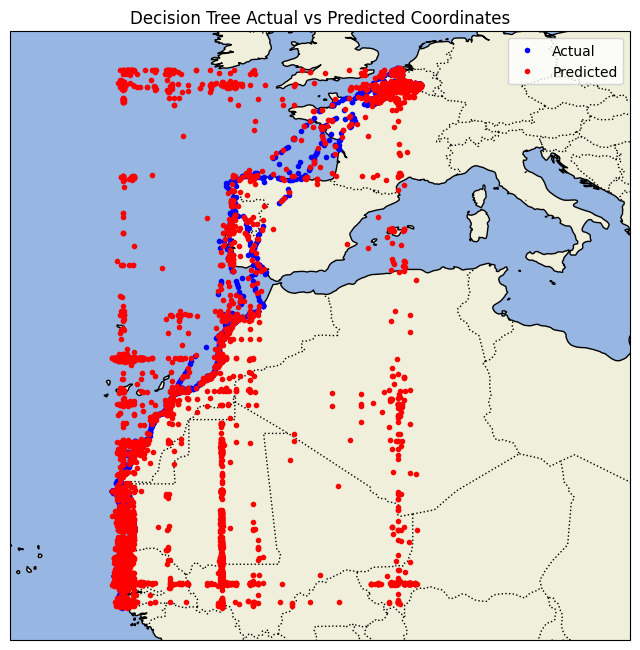

In [99]:
# Visualize decision tree model predictions
y_pred_lat = dt_lat_model.predict(X1_test)
y_pred_long = dt_long_model.predict(X2_test)
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Configure the map features
ax.set_extent((-25.0,20.0,52.0,10.0))
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Plot the actual and predicted coordinates
ax.plot(y2_test, y1_test, ".", transform=ccrs.Geodetic(), color='blue', label='Actual')
ax.plot(y_pred_long, y_pred_lat, ".", transform=ccrs.Geodetic(), color='red', label='Predicted')

plt.legend()
plt.title('Decision Tree Actual vs Predicted Coordinates')
plt.show()

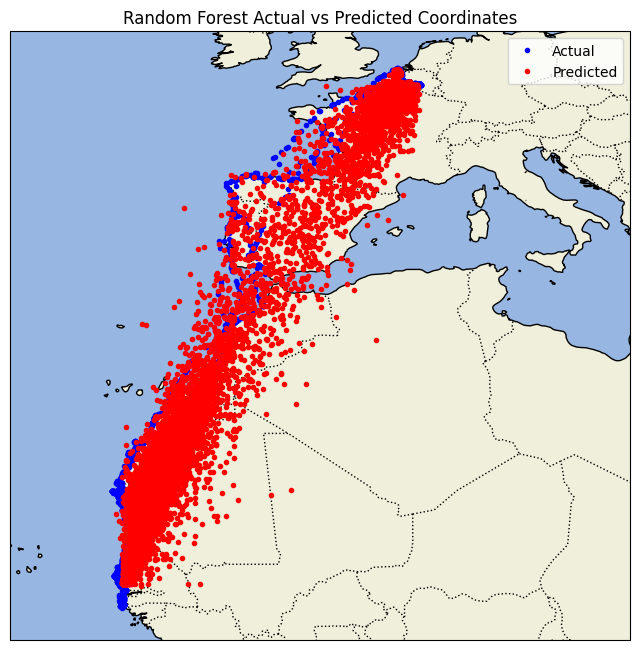

In [100]:
# Visualize multi-output random forest model predictions
y_pred_lat_long = multi_rf_model.predict(X3_test)
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Configure the map features
ax.set_extent((-25.0,20.0,52.0,10.0))
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Plot the actual and predicted coordinates
ax.plot(y3_test['longitude'], y3_test['latitude'], ".", transform=ccrs.Geodetic(), color='blue', label='Actual')
ax.plot(y_pred_lat_long[:, 1], y_pred_lat_long[:, 0], ".", transform=ccrs.Geodetic(), color='red', label='Predicted')

plt.legend()
plt.title('Random Forest Actual vs Predicted Coordinates')
plt.show()

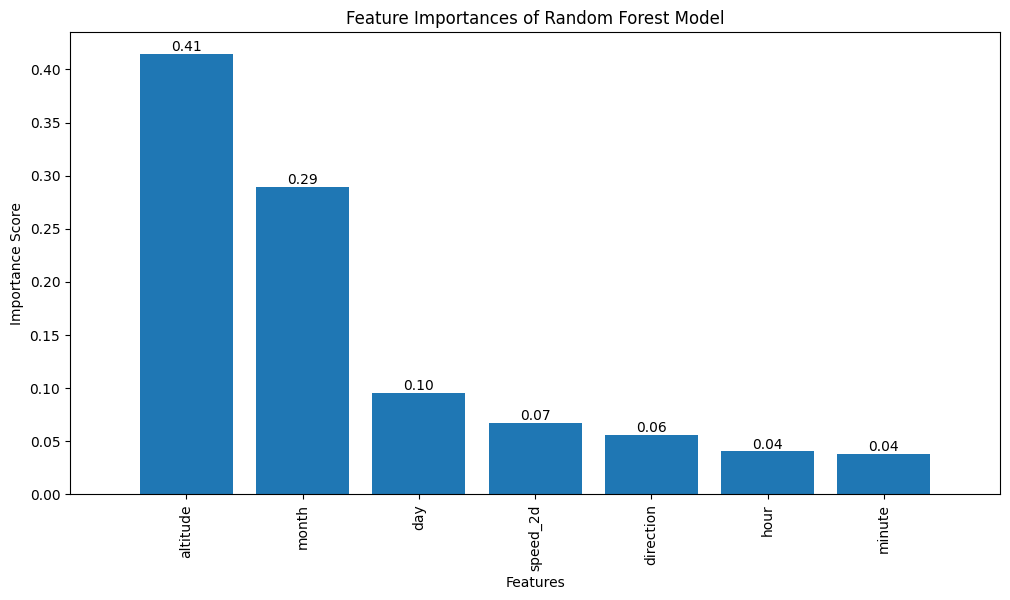

In [101]:
# Get feature importances
importances = multi_rf_model.estimators_[0].feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X3_test.columns

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances of Random Forest Model")
bars = plt.bar(range(X3_test.shape[1]), importances[indices], align="center")
plt.xticks(range(X3_test.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X3_test.shape[1]])
plt.xlabel('Features')
plt.ylabel('Importance Score')

# Add importance values above each bar
for bar, importance in zip(bars, importances[indices]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{importance:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.show()

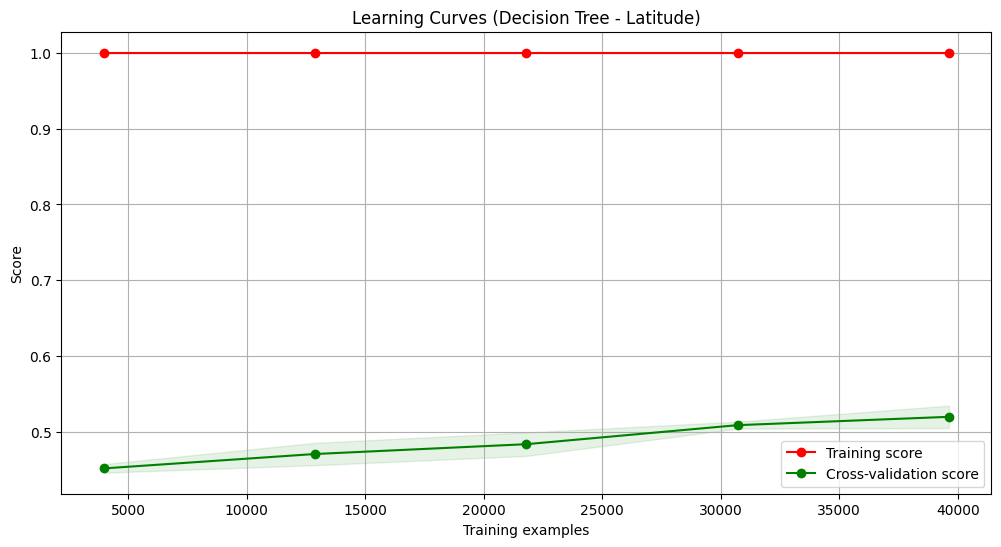

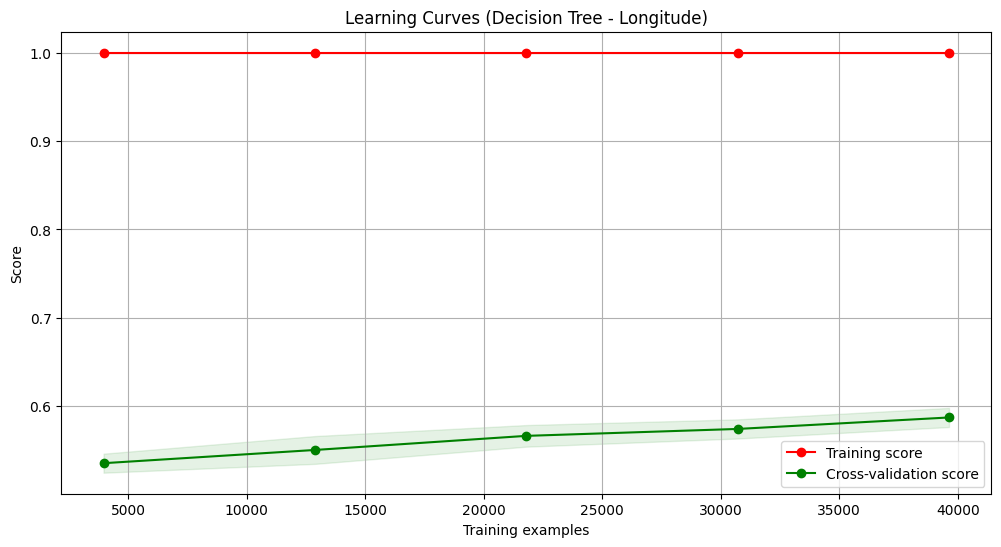

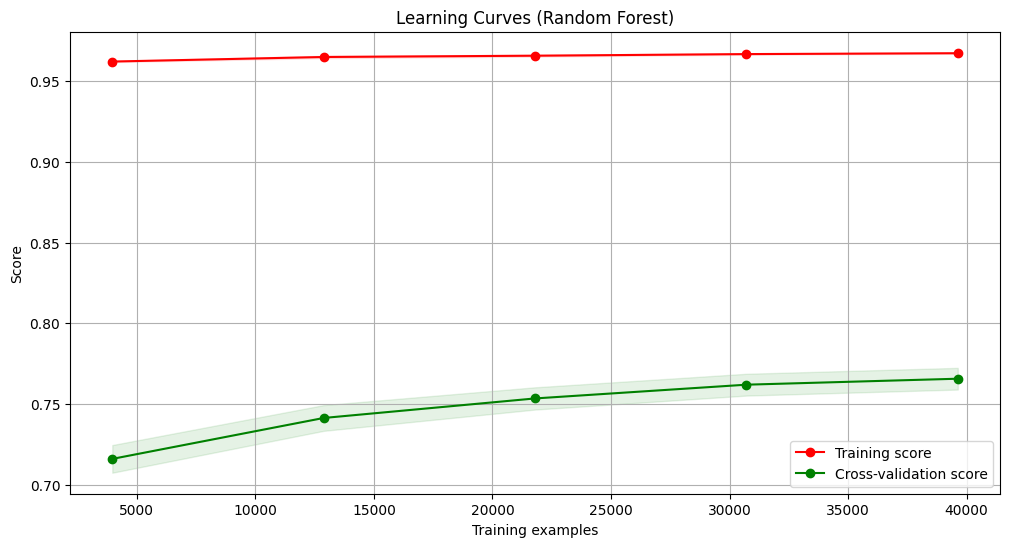

In [102]:
# Generate learning curves for the models
def plot_learning_curve(title, train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Generate learning curves for decision tree (latitude)
train_sizes, train_scores_lat, test_scores_lat = learning_curve(dt_lat_model, X1_train, y1_train, cv=5, scoring='r2', n_jobs=-1)
train_scores_mean_lat = np.mean(train_scores_lat, axis=1)
train_scores_std_lat = np.std(train_scores_lat, axis=1)
test_scores_mean_lat = np.mean(test_scores_lat, axis=1)
test_scores_std_lat = np.std(test_scores_lat, axis=1)

# Plot learning curves for latitude
plot_learning_curve("Learning Curves (Decision Tree - Latitude)", train_sizes, train_scores_mean_lat, train_scores_std_lat, test_scores_mean_lat, test_scores_std_lat)

# Generate learning curves for decision tree (longitude)
train_sizes, train_scores_lon, test_scores_lon = learning_curve(dt_long_model, X2_train, y2_train, cv=5, scoring='r2', n_jobs=-1)
train_scores_mean_lon = np.mean(train_scores_lon, axis=1)
train_scores_std_lon = np.std(train_scores_lon, axis=1)
test_scores_mean_lon = np.mean(test_scores_lon, axis=1)
test_scores_std_lon = np.std(test_scores_lon, axis=1)

# Plot learning curves for longitude
plot_learning_curve("Learning Curves (Decision Tree - Longitude)", train_sizes, train_scores_mean_lon, train_scores_std_lon, test_scores_mean_lon, test_scores_std_lon)

# Generate learning curves for multi-output random forest
train_sizes, train_scores_rf, test_scores_rf = learning_curve(multi_rf_model, X3_train, y3_train, cv=5, scoring='r2', n_jobs=-1)
train_scores_mean_rf = np.mean(train_scores_rf, axis=1)
train_scores_std_rf = np.std(train_scores_rf, axis=1)
test_scores_mean_rf = np.mean(test_scores_rf, axis=1)
test_scores_std_rf = np.std(test_scores_rf, axis=1)

# Plot learning curves for random forest
plot_learning_curve("Learning Curves (Random Forest)", train_sizes, train_scores_mean_rf, train_scores_std_rf, test_scores_mean_rf, test_scores_std_rf)
